# Error interference in the second-order Product formula

In [7]:
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import SparsePauliOp
# from numpy.linalg import norm
import numpy as np
from scipy.linalg import expm
import scipy

from lattice_hamiltonians import *

In [ ]:
class TF_Ising_1d:
    def __init__(self, n: int, J=1, h=0.2, g=0.0, pbc=False, verbose=False):
        self.n = n
        self.zz_tuples = [('ZZ', [i, i + 1], -J) for i in range(0, n-1)]
        self.x_tuples = [('X', [i], -h) for i in range(0, n)] 
        self.z_tuples = [('Z', [i], -g) for i in range(0, n)] 
        if pbc: self.zz_tuples.append(('ZZ', [n-1, 0], -J))

        self.ham = SparsePauliOp.from_sparse_list([*self.zz_tuples, *self.x_tuples, *self.z_tuples], num_qubits=n).simplify()
        if verbose: print('The Hamiltonian: \n', self.ham)
        self.parity_group()
        self.xyz_group()

    def parity_group(self):
        # return self.ham.to_matrix().todense()
        self.ham_parity = [SparsePauliOp.from_sparse_list([*self.zz_tuples[::2], *self.x_tuples[::2], *self.z_tuples[::2]], num_qubits=self.n).simplify(), SparsePauliOp.from_sparse_list([*self.zz_tuples[1::2], *self.x_tuples[1::2], *self.z_tuples[1::2]], num_qubits=self.n).simplify()]

    def xyz_group(self):
        self.ham_xyz = [SparsePauliOp.from_sparse_list([*self.zz_tuples, *self.z_tuples], num_qubits=self.n).simplify(), SparsePauliOp.from_sparse_list([*self.x_tuples], num_qubits=self.n)]

def standard_trotter(h_list, t, r, ord=2, verbose=False):
    """
    [todo higher order]
    Args:
        h_list (list): A list of Hamiltonian terms (even/odd parity partition).
        t (float): The time step.

    Returns:

    """
    # list_U = [ssla.expm(-1j * (t / r) * herm) for herm in ising_1d.h_list]
    if ord == 2:
        list_U = [scipy.linalg.expm(-1j * (t / (2*r)) * herm.toarray()) for herm in h_list]
        if verbose: print('----expm Herm finished----')
        appro_U_dt = list_U[0] @ list_U[1]
        if verbose: print('----matrix product finished----')
        appro_U = np.linalg.matrix_power(appro_U_dt @ list_U[1] @ list_U[0], r)
        # appro_U = jnp.linalg.matrix_power(appro_U_dt, r)
        # appro_U = matrix_power(appro_U_dt, r)
        # appro_U = matrix_power(appro_U_dt.toarray(), r)
        if verbose: print('----matrix power finished----')
    elif ord == 1:
        list_U = [scipy.linalg.expm(-1j * (t / (r)) * herm.toarray()) for herm in h_list]
        appro_U_dt = list_U[0] @ list_U[1]
        appro_U = np.linalg.matrix_power(appro_U_dt, r)

    return appro_U


r_list:  [ 10  11  12  14  16  18  20  23  25  29  32  37  41  47  52  59  67  75
  85  96 108 121 137 154 174 196 221 249 280 316]
SparsePauliOp(['IIIIIZZ', 'IIIIZZI', 'IIIZZII', 'IIZZIII', 'IZZIIII', 'ZZIIIII', 'IIIIIIX', 'IIIIIXI', 'IIIIXII', 'IIIXIII', 'IIXIIII', 'IXIIIII', 'XIIIIII'],
              coeffs=[-2.  +0.j, -2.  +0.j, -2.  +0.j, -2.  +0.j, -2.  +0.j, -2.  +0.j,
 -0.01+0.j, -0.01+0.j, -0.01+0.j, -0.01+0.j, -0.01+0.j, -0.01+0.j,
 -0.01+0.j])
xyz:  [SparsePauliOp(['IIIIIZZ', 'IIIIZZI', 'IIIZZII', 'IIZZIII', 'IZZIIII', 'ZZIIIII'],
              coeffs=[-2.+0.j, -2.+0.j, -2.+0.j, -2.+0.j, -2.+0.j, -2.+0.j]), SparsePauliOp(['IIIIIIX', 'IIIIIXI', 'IIIIXII', 'IIIXIII', 'IIXIIII', 'IXIIIII', 'XIIIIII'],
              coeffs=[-0.01+0.j, -0.01+0.j, -0.01+0.j, -0.01+0.j, -0.01+0.j, -0.01+0.j,
 -0.01+0.j])]
parity:  [SparsePauliOp(['IIIIIZZ', 'IIIZZII', 'IZZIIII', 'IIIIIIX', 'IIIIXII', 'IIXIIII', 'XIIIIII'],
              coeffs=[-2.  +0.j, -2.  +0.j, -2.  +0.j, -0.01+0.j, -0.01+0.j,

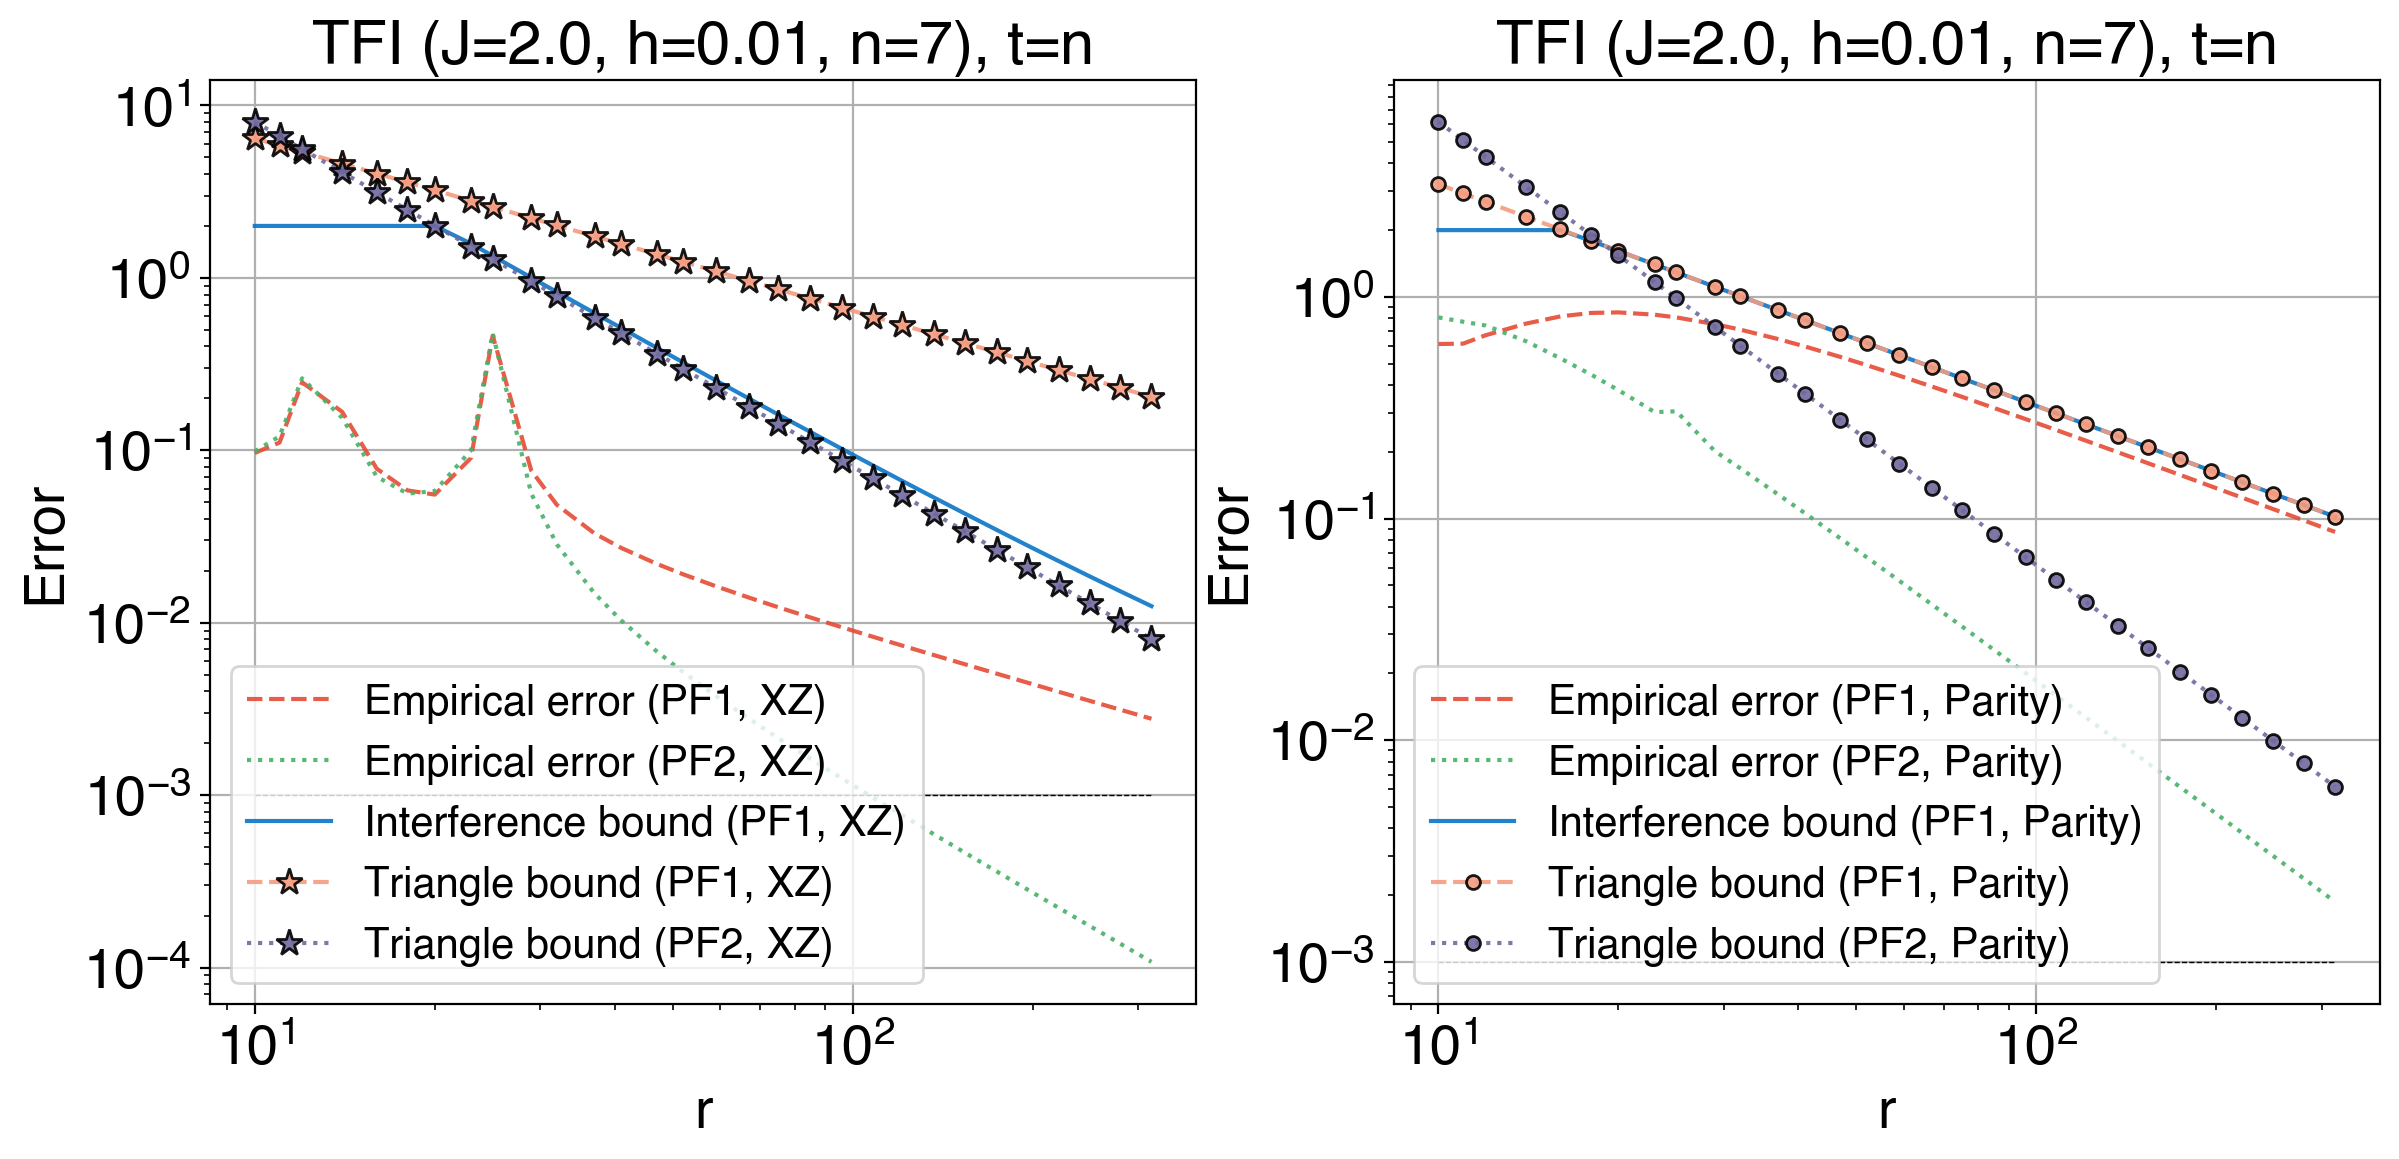

In [37]:
J=2.0; h=0.01; 
r_list = np.logspace(1, 2.5, 30, dtype=int)
print("r_list: ", r_list)
n = 7
err_list_pf1_xyz, err_list_pf2_xyz = [], []
err_list_pf1_par, err_list_pf2_par = [], []

tfI = TF_Ising_1d(n=n, J=J, h=h, pbc=False)
print(tfI.ham)
print("xyz: ", tfI.ham_xyz)
print("parity: ", tfI.ham_parity)
t = 20
for r in r_list:
    exact_U = expm(-1j * t * tfI.ham.to_matrix())
    appro_U_xyz_pf1 = standard_trotter([h.to_matrix(True) for h in tfI.ham_xyz], t, r, ord=1)
    appro_U_xyz_pf2 = standard_trotter([h.to_matrix(True) for h in tfI.ham_xyz], t, r, ord=2)
    appro_U_par_pf1 = standard_trotter([h.to_matrix(True) for h in tfI.ham_parity], t, r, ord=1)
    appro_U_par_pf2 = standard_trotter([h.to_matrix(True) for h in tfI.ham_parity], t, r, ord=2)
    err_list_pf1_xyz.append(norm(exact_U - appro_U_xyz_pf1))
    err_list_pf2_xyz.append(norm(exact_U - appro_U_xyz_pf2))
    err_list_pf1_par.append(norm(exact_U - appro_U_par_pf1))
    err_list_pf2_par.append(norm(exact_U - appro_U_par_pf2))

xyz_group = [h.to_matrix() for h in tfI.ham_xyz]
par_group = [h.to_matrix() for h in tfI.ham_parity]
# print(par_group)

interf_bound_par = np.array([interference_bound(par_group, t, r) for r in r_list])
# print('interf_bound_par:', interf_bound_par)
interf_bound_xyz = np.array([interference_bound(xyz_group, t, r) for r in r_list])

e_pf1_tight_xyz = np.array([tight_bound(xyz_group, 1, t, r) for r in r_list])
e_pf1_tight_par = np.array([tight_bound(par_group, 1, t, r) for r in r_list])
e_pf2_tight_xyz = np.array([tight_bound(xyz_group, 2, t, r) for r in r_list])
e_pf2_tight_par = np.array([tight_bound(par_group, 2, t, r) for r in r_list])


In [ ]:
## visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

axes[0].plot(r_list, err_list_pf1_xyz, '--', label='Empirical error (PF1, XZ)')
axes[0].plot(r_list, err_list_pf2_xyz, ':', label='Empirical error (PF2, XZ)')
axes[1].plot(r_list, err_list_pf1_par, '--', label='Empirical error (PF1, Parity)')
axes[1].plot(r_list, err_list_pf2_par, ':', label='Empirical error (PF2, Parity)')
axes[1].plot(r_list, interf_bound_par[:, 0], '-', label='Interference bound (PF1, Parity)')
axes[0].plot(r_list, interf_bound_xyz[:, 0], '-', label='Interference bound (PF1, XZ)')
axes[1].plot(r_list, e_pf1_tight_par, '.--', label='Triangle bound (PF1, Parity)')
axes[0].plot(r_list, e_pf1_tight_xyz, '*--', label='Triangle bound (PF1, XZ)')
axes[1].plot(r_list, e_pf2_tight_par, '.:', label='Triangle bound (PF2, Parity)')
axes[0].plot(r_list, e_pf2_tight_xyz, '*:', label='Triangle bound (PF2, XZ)')
for ax in axes:
    ax.hlines(1e-3, r_list[0], r_list[-1], 'k', '--', linewidth=0.5)
    ax.set_xlabel('r')
    ax.set_ylabel('Error')
    ax.set_title(f'TFI (J={J}, h={h}, n={n}), t=n')
    ax.loglog()
    ax.legend()
    # ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
    ax.grid()

In [47]:
from cmath import log, exp
from scipy.optimize import curve_fit
def linear_loglog_fit(x, y, verbose=False):
    # Define the linear function
    def linear_func(x, a, b):
        return a * x + b

    log_x = np.array([log(n) for n in x])
    log_y = np.array([log(cost) for cost in y])
    # Fit the linear function to the data
    params, covariance = curve_fit(linear_func, log_x, log_y)
    # Extract the parameters
    a, b = params
    # Predict y values
    y_pred = linear_func(log_x, a, b)
    # Print the parameters
    if verbose: print('Slope (a):', a, 'Intercept (b):', b)
    exp_y_pred = [exp(cost) for cost in y_pred]

    return exp_y_pred, a, b

def plot_fit(ax, x, y, var='n', offset=1.07, verbose=True):
    y_pred_em, a_em, b_em = linear_loglog_fit(x, y)
    if verbose: print(f'a_em: {a_em}; b_em: {b_em}')
    text_a_em = "{:.2f}".format(round(abs(a_em), 4))
    y_pred_em = [exp(cost) for cost in a_em*np.array([log(n) for n in x]) + b_em]
    ax.plot(x, y_pred_em, 'k--', linewidth=1)
    ax.annotate(r'$O(%s^{%s})$' % (var, text_a_em), xy=(x[-1], np.real(y_pred_em)[-1]), xytext=(x[-1]*offset, np.real(y_pred_em)[-1]))

---------Heisenberg Hamiltonian---------
inter_xx: ['XXIIIII', 'IXXIIII', 'IIXXIII', 'IIIXXII', 'IIIIXXI', 'IIIIIXX', 'XIIIIIX']
inter_yy: ['YYIIIII', 'IYYIIII', 'IIYYIII', 'IIIYYII', 'IIIIYYI', 'IIIIIYY', 'YIIIIIY']
inter_zz: ['ZZIIIII', 'IZZIIII', 'IIZZIII', 'IIIZZII', 'IIIIZZI', 'IIIIIZZ', 'ZIIIIIZ']
external ['ZIIIIII', 'IZIIIII', 'IIZIIII', 'IIIZIII', 'IIIIZII', 'IIIIIZI', 'IIIIIIZ']
---------Partitioned Hamiltonian---------
inter_xx_even: ['XXIIIII', 'IIXXIII', 'IIIIXXI', 'XIIIIIX']
inter_xx_odd: ['IXXIIII', 'IIIXXII', 'IIIIIXX']
external_even ['ZIIIIII', 'IIZIIII', 'IIIIZII', 'IIIIIIZ']
external_odd ['IZIIIII', 'IIIZIII', 'IIIIIZI']


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


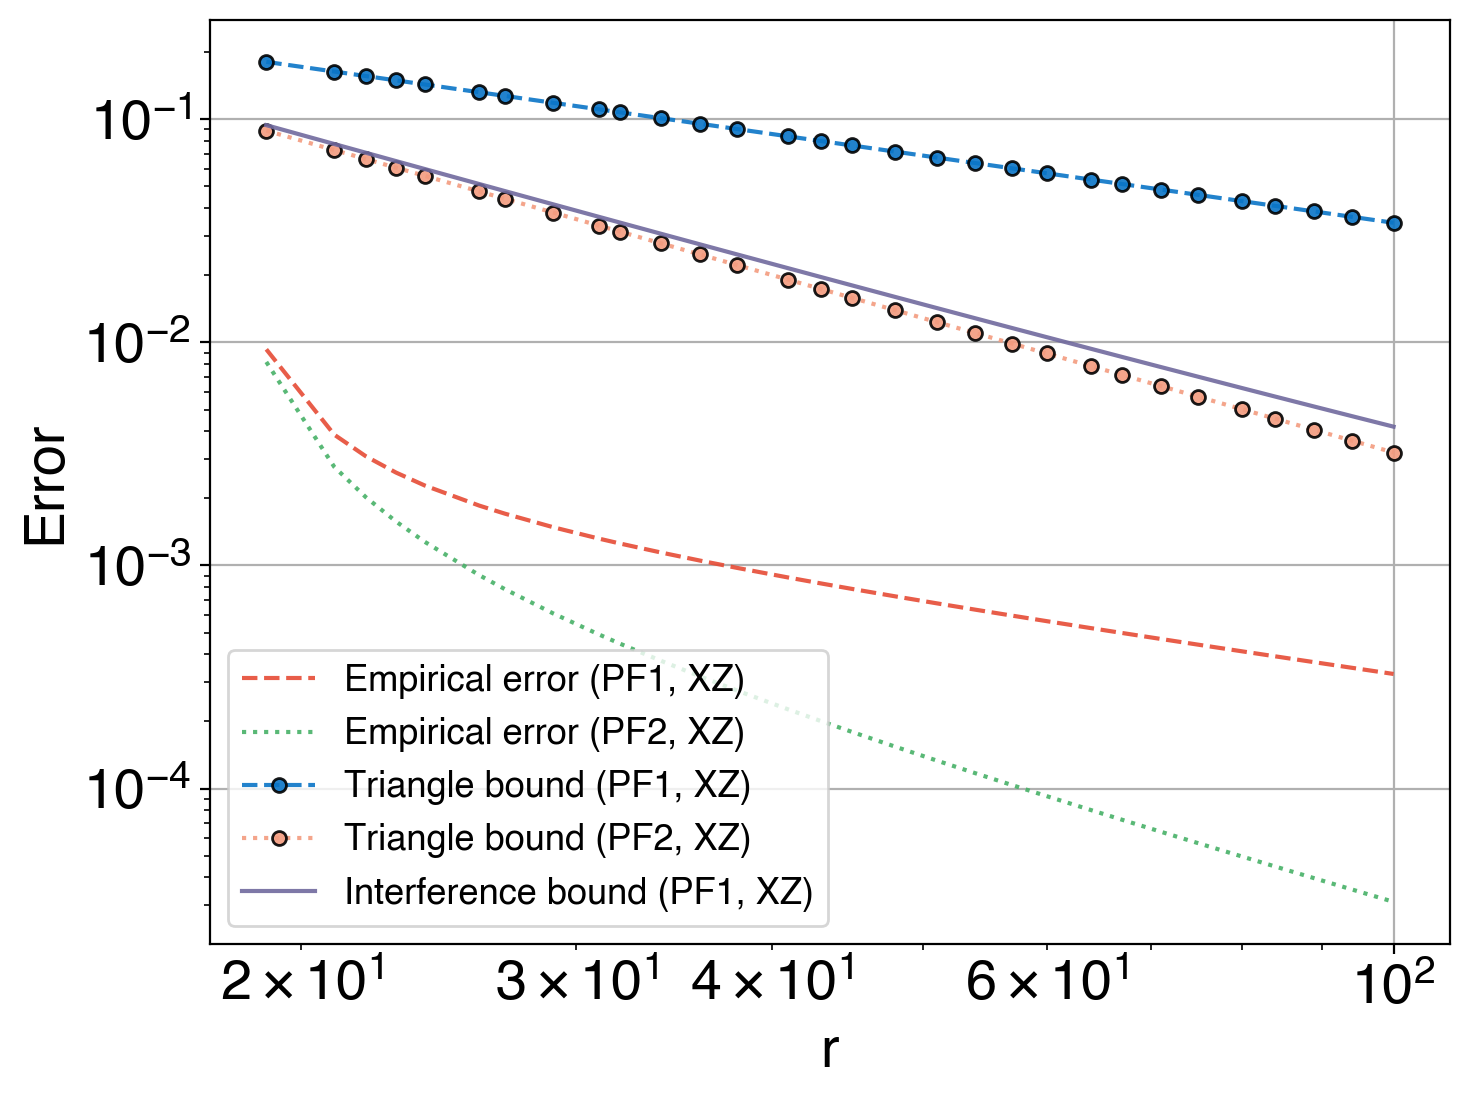

In [24]:
from scipy.sparse import csr_matrix

err_norm = 'spectral' # HS, spectral
n = 7; epsilon = 0.001
t = 2 * n
J_x, J_y, J_z, h = 2.0, 0.0, 0.0, 0.001
# J_x, J_y, J_z, h = 2.0, 2.0, 2.0, 0.5
# J_x, J_y, J_z, h = 1.5, 1.5, 1.5, 1.1
heisenberg = heisenberg_1d(n=n, Jx=J_x, Jy=J_y, Jz=J_z, h=h, verbose=True)
# print(heisenberg.xx)
heisenberg.partition(method='parity', verbose=True)
heisenberg.partition(method='tri', verbose=True)
parity_group_sparse = [csr_matrix(heisenberg.even), csr_matrix(heisenberg.odd)]
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
# parity_label = ['even-odd', 'odd-even']; parity_markers = ['*:', '.--']

tri_group_sparse = [csr_matrix(heisenberg.term0), csr_matrix(heisenberg.term1), csr_matrix(heisenberg.term2)]
tri_group = [heisenberg.term0.to_matrix(), heisenberg.term1.to_matrix(), heisenberg.term2.to_matrix()]

# r_list = np.logspace(2, 6, num=30, dtype=int)
r_list = np.logspace(1.3, 2, num=30, dtype=int)
# r_list = np.logspace(1.0, 2, num=30, dtype=int)
# r_list = np.logspace(1.0, 2, num=30, dtype=int)
# r_list_truncated = np.logspace(2, 6, num=30, dtype=int)

interf_bound_par = np.array([interference_bound(parity_group, t, r) for r in r_list])

xyz_group_sparse = [csr_matrix(heisenberg.xx), csr_matrix(heisenberg.yy), csr_matrix(heisenberg.zz) + csr_matrix(heisenberg.z)]
xyz_group = [heisenberg.xx.to_matrix() , heisenberg.yy.to_matrix(), heisenberg.zz.to_matrix() + heisenberg.z.to_matrix()]
interf_bound_xyz = np.array([interference_bound([heisenberg.xx.to_matrix() , heisenberg.zz.to_matrix() + heisenberg.z.to_matrix()], t, r) for r in r_list])

e_pf1_tight_xyz = np.array([tight_bound(xyz_group, 1, t, r) for r in r_list])
e_pf2_tight_xyz = np.array([tight_bound(xyz_group, 2, t, r) for r in r_list])
e_pf1_tight_par = np.array([tight_bound(parity_group, 1, t, r) for r in r_list])
e_pf2_tight_par = np.array([tight_bound(parity_group, 2, t, r) for r in r_list])

exact_U = expm(-1j * t * sum(xyz_group))
# exact_U = expm(-1j * t * sum(parity_group))
pf1_parity_list = [op_error(unitary_matrix_product(parity_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
pf2_parity_list = [op_error((unitary_matrix_product(parity_group_sparse, t=t/(2*r)) @ unitary_matrix_product(parity_group_sparse[::-1], t=t/(2*r)))**r, exact_U) for r in r_list]
pf1_xyz_list = [op_error(unitary_matrix_product(xyz_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
pf2_xyz_list = [op_error((unitary_matrix_product(xyz_group_sparse, t=t/(2*r)) @ unitary_matrix_product(xyz_group_sparse[::-1], t=t/(2*r)))**r, exact_U) for r in r_list]

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
# ax.hlines(1e-3, r_list[0], r_list[-1], 'k', '--', linewidth=0.5)

# ax.plot(r_list, pf1_parity_list, '.-', label='Empirical error (PF1, Parity)')
# ax.plot(r_list, pf2_parity_list, '.--', label='Empirical error (PF2, Parity)')
# ax.plot(r_list, e_pf2_tight_par, '.:', label='Triangle bound (PF2, Parity)')
ax.plot(r_list, pf1_xyz_list, '--', label='Empirical error (PF1, XZ)')
ax.plot(r_list, pf2_xyz_list, ':', label='Empirical error (PF2, XZ)')
ax.plot(r_list, e_pf1_tight_xyz, '.--', label='Triangle bound (PF1, XZ)')
ax.plot(r_list, e_pf2_tight_xyz, '.:', label='Triangle bound (PF2, XZ)')
# ax.plot(r_list, err_list, '--', label='Empirical error (PF2)')
# ax.plot(r_list, interf_bound_par[:, 0], '-', label='Interference bound (PF1, Parity)')
ax.plot(r_list, interf_bound_xyz[:, 0], '-', label='Interference bound (PF1, XZ)')
# ax.plot(r_list, e_pf1_tight_par, '.-', label='Triangle bound (PF1, Parity)')
ax.set_xlabel('r')
ax.set_ylabel('Error')
# ax.set_title(fr'Heisenberg ($J_x={J_x}, J_y={J_y}, J_z={J_z}$, h={h}, n={n}), t=n')
ax.loglog()
# ax.set_ylim(1e-5, 5e0)
ax.grid()
ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
fig.savefig(f'./figs/ising_pf2_n={n}.pdf', bbox_inches='tight')

---------Heisenberg Hamiltonian---------
inter_xx: ['XXIIIII', 'IXXIIII', 'IIXXIII', 'IIIXXII', 'IIIIXXI', 'IIIIIXX', 'XIIIIIX']
inter_yy: ['YYIIIII', 'IYYIIII', 'IIYYIII', 'IIIYYII', 'IIIIYYI', 'IIIIIYY', 'YIIIIIY']
inter_zz: ['ZZIIIII', 'IZZIIII', 'IIZZIII', 'IIIZZII', 'IIIIZZI', 'IIIIIZZ', 'ZIIIIIZ']
external ['ZIIIIII', 'IZIIIII', 'IIZIIII', 'IIIZIII', 'IIIIZII', 'IIIIIZI', 'IIIIIIZ']
---------Partitioned Hamiltonian---------
inter_xx_even: ['XXIIIII', 'IIXXIII', 'IIIIXXI', 'XIIIIIX']
inter_xx_odd: ['IXXIIII', 'IIIXXII', 'IIIIIXX']
external_even ['ZIIIIII', 'IIZIIII', 'IIIIZII', 'IIIIIIZ']
external_odd ['IZIIIII', 'IIIZIII', 'IIIIIZI']


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


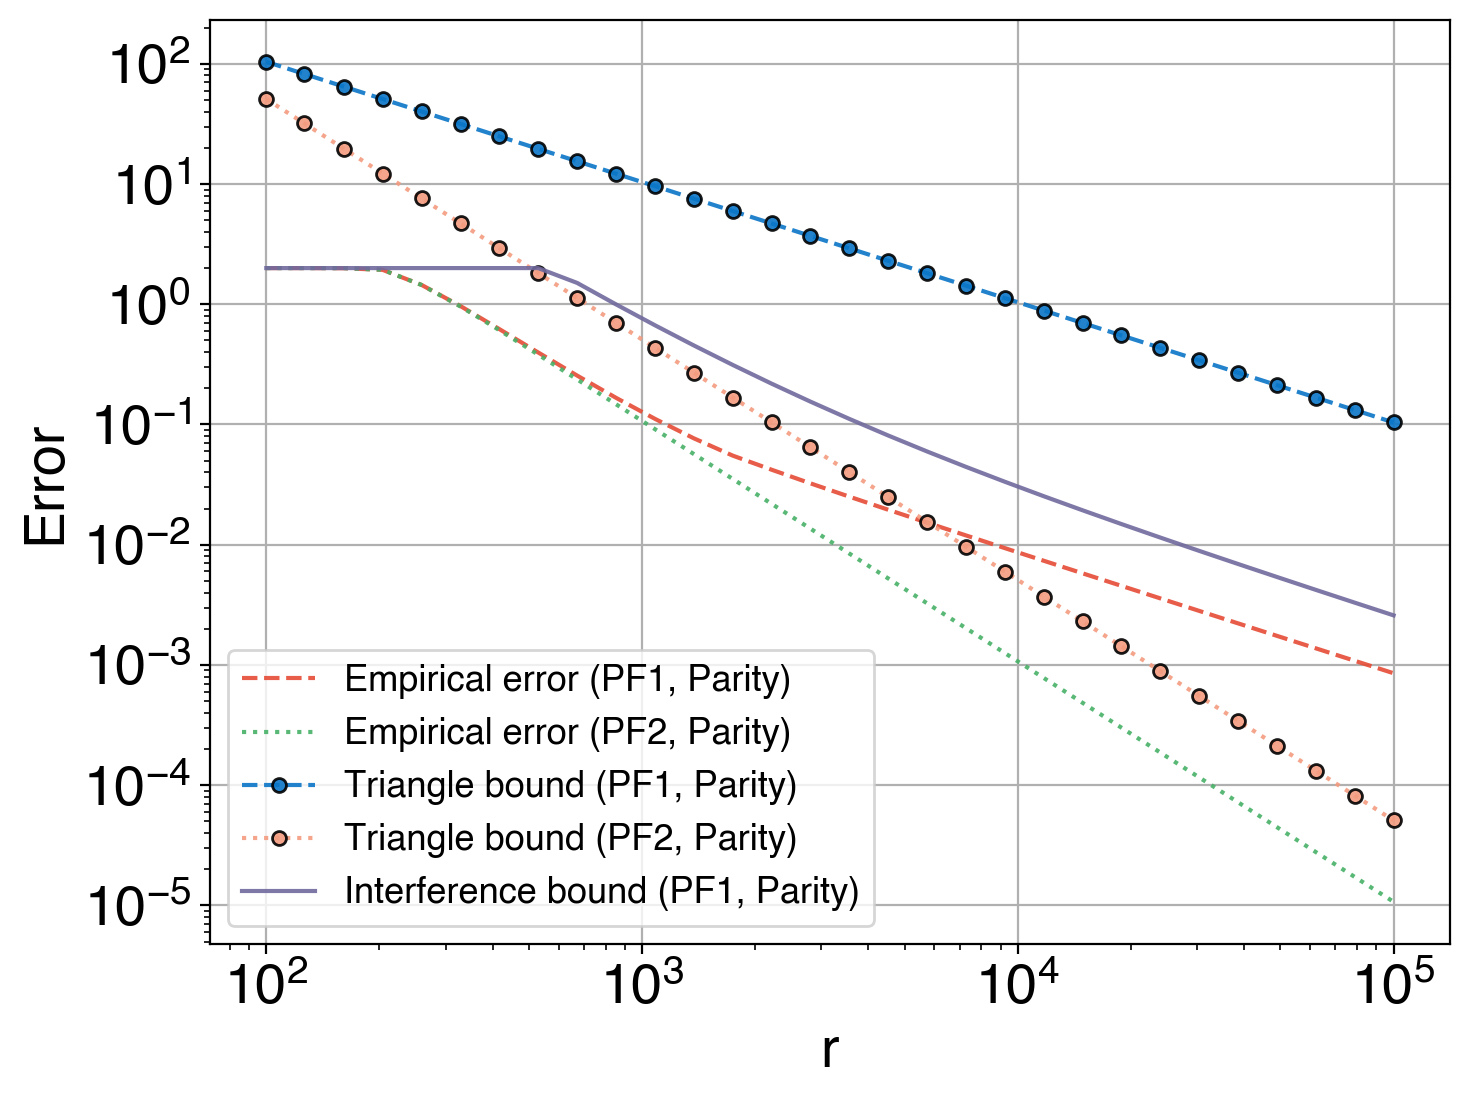

In [30]:
from scipy.sparse import csr_matrix

err_norm = 'spectral' # HS, spectral
n = 7; epsilon = 0.001
t = 2 * n
# J_x, J_y, J_z, h = 2.0, 0.0, 0.0, 0.001
J_x, J_y, J_z, h = 2.0, 2.0, 2.0, 0.5
# J_x, J_y, J_z, h = 1.5, 1.5, 1.5, 1.1
heisenberg = heisenberg_1d(n=n, Jx=J_x, Jy=J_y, Jz=J_z, h=h, verbose=True)
# print(heisenberg.xx)
heisenberg.partition(method='parity', verbose=True)
heisenberg.partition(method='tri', verbose=True)
parity_group_sparse = [csr_matrix(heisenberg.even), csr_matrix(heisenberg.odd)]
parity_group = [heisenberg.even.to_matrix(), heisenberg.odd.to_matrix()]
# parity_label = ['even-odd', 'odd-even']; parity_markers = ['*:', '.--']

tri_group_sparse = [csr_matrix(heisenberg.term0), csr_matrix(heisenberg.term1), csr_matrix(heisenberg.term2)]
tri_group = [heisenberg.term0.to_matrix(), heisenberg.term1.to_matrix(), heisenberg.term2.to_matrix()]

r_list = np.logspace(2, 5, num=30, dtype=int)
# r_list = np.logspace(1.3, 2, num=30, dtype=int)
# r_list = np.logspace(1.0, 2, num=30, dtype=int)
# r_list = np.logspace(1.0, 2, num=30, dtype=int)
# r_list_truncated = np.logspace(2, 6, num=30, dtype=int)

interf_bound_par = np.array([interference_bound(parity_group, t, r) for r in r_list])

xyz_group_sparse = [csr_matrix(heisenberg.xx), csr_matrix(heisenberg.yy), csr_matrix(heisenberg.zz) + csr_matrix(heisenberg.z)]
xyz_group = [heisenberg.xx.to_matrix() , heisenberg.yy.to_matrix(), heisenberg.zz.to_matrix() + heisenberg.z.to_matrix()]
interf_bound_xyz = np.array([interference_bound([heisenberg.xx.to_matrix() , heisenberg.zz.to_matrix() + heisenberg.z.to_matrix()], t, r) for r in r_list])

e_pf1_tight_xyz = np.array([tight_bound(xyz_group, 1, t, r) for r in r_list])
e_pf2_tight_xyz = np.array([tight_bound(xyz_group, 2, t, r) for r in r_list])
e_pf1_tight_par = np.array([tight_bound(parity_group, 1, t, r) for r in r_list])
e_pf2_tight_par = np.array([tight_bound(parity_group, 2, t, r) for r in r_list])

exact_U = expm(-1j * t * sum(xyz_group))
# exact_U = expm(-1j * t * sum(parity_group))
pf1_parity_list = [op_error(unitary_matrix_product(parity_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
pf2_parity_list = [op_error((unitary_matrix_product(parity_group_sparse, t=t/(2*r)) @ unitary_matrix_product(parity_group_sparse[::-1], t=t/(2*r)))**r, exact_U) for r in r_list]
pf1_xyz_list = [op_error(unitary_matrix_product(xyz_group_sparse, t=t/r)**r, exact_U, err_norm) for r in r_list]
pf2_xyz_list = [op_error((unitary_matrix_product(xyz_group_sparse, t=t/(2*r)) @ unitary_matrix_product(xyz_group_sparse[::-1], t=t/(2*r)))**r, exact_U) for r in r_list]

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
# ax.hlines(1e-3, r_list[0], r_list[-1], 'k', '--', linewidth=0.5)

ax.plot(r_list, pf1_parity_list, '--', label='Empirical error (PF1, Parity)')
ax.plot(r_list, pf2_parity_list, ':', label='Empirical error (PF2, Parity)')
ax.plot(r_list, e_pf1_tight_par, '.--', label='Triangle bound (PF1, Parity)')
ax.plot(r_list, e_pf2_tight_par, '.:', label='Triangle bound (PF2, Parity)')
# ax.plot(r_list, pf1_xyz_list, '--', label='Empirical error (PF1, XZ)')
# ax.plot(r_list, pf2_xyz_list, ':', label='Empirical error (PF2, XZ)')
# ax.plot(r_list, e_pf1_tight_xyz, '.--', label='Triangle bound (PF1, XZ)')
# ax.plot(r_list, e_pf2_tight_xyz, '.:', label='Triangle bound (PF2, XZ)')
# ax.plot(r_list, err_list, '--', label='Empirical error (PF2)')
ax.plot(r_list, interf_bound_par[:, 0], '-', label='Interference bound (PF1, Parity)')
# ax.plot(r_list, interf_bound_xyz[:, 0], '-', label='Interference bound (PF1, XZ)')
ax.set_xlabel('r')
ax.set_ylabel('Error')
# ax.set_title(fr'Heisenberg ($J_x={J_x}, J_y={J_y}, J_z={J_z}$, h={h}, n={n}), t=n')
ax.loglog()
# ax.set_ylim(1e-5, 5e0)
ax.grid()
ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
fig.savefig(f'./figs/Heisenberg_pf2_n={n}.pdf', bbox_inches='tight')